<a href="https://colab.research.google.com/github/edegp/food_cnn/blob/main/ConvNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %cd ConvNeXt/
# !wget https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth

In [2]:
# !git clone https://github.com/facebookresearch/ConvNeXt

In [3]:
import pandas as pd

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

In [4]:
demog = pd.read_csv("/content/drive/My Drive/foodReward/data/data_demographic_NCNP.csv")
ques = pd.read_csv("/content/drive/My Drive/foodReward/data/data_questionnare_NCNP.csv")
resp = pd.read_csv("/content/drive/My Drive/foodReward/data/data_responses_NCNP_2types.csv")

In [5]:
res_L_mean = resp.groupby("img")["res_L"].mean()

In [6]:


# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir: str, label_series:pd.Series, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Replace 0 with actual label if available
        label = res_L_mean[idx]

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
image_dir = '/content/drive/My Drive/foodReward/data/Database'
dataset = ImageDataset(image_dir=image_dir,label_series= res_L_mean, transform=transform)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Sample batch
for images, labels in data_loader:
    print(f'Batch of images shape: {images.shape}')
    print(f'Batch of labels shape: {labels.shape}')
    break

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


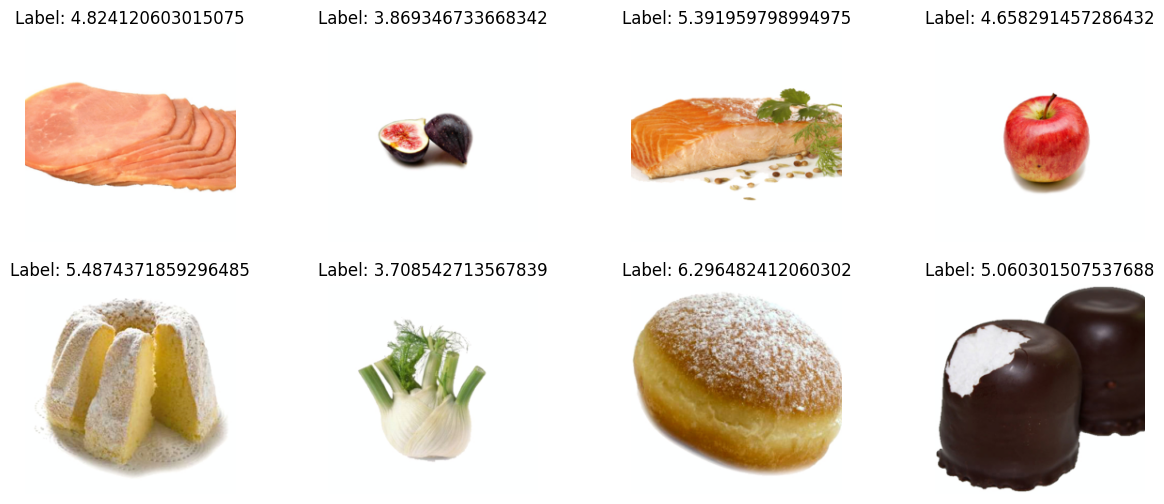

In [7]:
# Function to visualize a batch of images
def show_images(images, labels, n=8):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        ax = plt.subplot(2, n//2, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = img.clip(0, 1)
        plt.imshow(img)
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# Get a batch of images and labels from the data loader
images, labels = next(iter(data_loader))
show_images(images, labels, n=8)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny

# Define transformations for training and validation datasets
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Define split sizes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained ConvNeXt model
model = convnext_tiny(pretrained=True)

# Modify the classifier to output a single continuous value for regression
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 1)

# Loss function and optimizer for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Fine-tuning function for regression
def fine_tune_regression(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

        # Evaluate the model on validation data
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

        print(f'Validation Loss: {total_loss/len(val_loader)}')

# Fine-tune the model for regression
fine_tune_regression(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 148MB/s] 


KeyError: 0